In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import numpy as np
from skimage.color import rgb2lab

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class ColorizationModel(nn.Module):
    def __init__(self):
        super(ColorizationModel, self).__init__()

        # Pre-trained ResNet50 encoder (modified to accept 1 channel input)
        self.encoder_resnet = models.resnet50(weights='IMAGENET1K_V1')
        self.encoder_resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.encoder_resnet = nn.Sequential(*list(self.encoder_resnet.children())[:-2])  # Remove the fully connected layer

        # Pre-trained DenseNet121 encoder (modified to accept 1 channel input)
        self.encoder_densenet = models.densenet121(weights='IMAGENET1K_V1')
        self.encoder_densenet.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.encoder_densenet = nn.Sequential(*list(self.encoder_densenet.children())[:-1])  # Use all layers except the classifier

        # Pooling layer to downsample DenseNet output to 7x7
        self.downsample_densenet = nn.AdaptiveAvgPool2d((7, 7))

        # 1x1 Convolution to reduce ResNet output to 1024 channels for element-wise maximum
        self.resnet_conv1x1 = nn.Conv2d(2048, 1024, kernel_size=1)

        # 1x1 Convolution to match DenseNet's output to 1024 channels if needed (keeping symmetry)
        self.densenet_conv1x1 = nn.Conv2d(1024, 1024, kernel_size=1)

        # Fusion Blocks
        self.fusion_block1 = nn.Sequential(
            nn.Conv2d(1024, 256, kernel_size=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.fusion_block2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.fusion_block3 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.fusion_block4 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        # Decoder Blocks (same as in the concatenation and averaging model)
        self.decoder_block1 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Upsample(scale_factor=2)
        )

        self.decoder_block2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Upsample(scale_factor=2)
        )

        self.decoder_block3 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Upsample(scale_factor=2)
        )

        self.decoder_block4 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Upsample(scale_factor=2)
        )

        self.decoder_block5 = nn.Sequential(
            nn.Conv2d(256, 2, kernel_size=3, padding=1),
            nn.Tanh(),  # Use Tanh to match output range [-1, 1]
            nn.Upsample(scale_factor=2)  # Upsample to 224 x 224
        )

    def forward(self, x):
        # Encoder
        x_resnet = self.encoder_resnet(x)  # ResNet output
        x_resnet = self.resnet_conv1x1(x_resnet)  # Reduce ResNet output to 1024 channels
        x_densenet = self.encoder_densenet(x)  # DenseNet output
        x_densenet = self.downsample_densenet(x_densenet)  # Downsample DenseNet output
        x_densenet = self.densenet_conv1x1(x_densenet)  # Match DenseNet output to 1024 channels

        # Fusion by element-wise maximum
        fb1_input = torch.max(x_resnet, x_densenet)  # Element-wise maximum fusion instead of averaging
        fb1_output = self.fusion_block1(fb1_input)

        fb2_input = fb1_output  # Use previous output only
        fb2_output = self.fusion_block2(fb2_input)

        fb3_input = fb2_output  # Use previous output only
        fb3_output = self.fusion_block3(fb3_input)

        fb4_input = fb3_output  # Use previous output only
        fb4_output = self.fusion_block4(fb4_input)

        # Decoder
        db1_output = self.decoder_block1(fb4_output)
        db2_output = self.decoder_block2(db1_output)
        db3_output = self.decoder_block3(db2_output)
        db4_output = self.decoder_block4(db3_output)

        output = self.decoder_block5(db4_output)

        return output


In [ ]:
# If you want to use GPU, ensure the model is moved to the GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Instantiate the model
model = ColorizationModel().to(device)

# Load the saved model
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Machine Learning Lab/Project/colorization_model_max.pth'))

# If you want to use GPU, ensure the model is moved to the GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

<ipython-input-6-7a2f71440dd9>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Machine Learning Lab

ColorizationModel(
  (encoder_resnet): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
         

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import lab2rgb

# Function to convert predicted 'L' and 'ab' channels to an RGB image
def lab_to_rgb(L, ab):
    L = L * 100  # Denormalize L channel from [0, 1] to [0, 100]
    ab = ab * 255 - 128  # Denormalize ab channels from [0, 1] to [-128, 128]

    lab = np.concatenate((L, ab), axis=2)  # Combine L and ab channels
    rgb_img = lab2rgb(lab)  # Convert Lab to RGB
    return rgb_img

In [ ]:
# Function to convert RGB images to L, a, and b channels in Lab color space
def rgb_to_lab(images):
    l_channels = []
    ab_channels = []
    for img in images:
        img = img.permute(1, 2, 0).cpu().numpy()  # Convert to HWC format and move to CPU
        lab_image = rgb2lab(img)  # Convert to CIE-Lab

        # Normalize L, a, and b channels
        L_channel = lab_image[:, :, 0] / 100.0  # Normalize L channel to [0, 1]
        a_channel = (lab_image[:, :, 1] + 128) / 255.0  # Normalize a channel to [0, 1]
        b_channel = (lab_image[:, :, 2] + 128) / 255.0  # Normalize b channel to [0, 1]

        l_channels.append(L_channel)
        ab_channels.append(np.stack((a_channel, b_channel), axis=-1))  # Stack a and b

    # Convert to PyTorch tensors
    L = torch.tensor(np.stack(l_channels), dtype=torch.float32).unsqueeze(1).to(device)  # (N, 1, H, W)
    ab = torch.tensor(np.stack(ab_channels), dtype=torch.float32).permute(0, 3, 1, 2).to(device)  # (N, 2, H, W)
    return L, ab

In [ ]:
# CIFAR10 Dataset Loader
def load_cifar10_dataset(batch_size=8, num_workers=2):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to match ResNet/DenseNet input size
        transforms.ToTensor(),  # Convert to tensor and scale to [0, 1]
    ])

    # Load the CIFAR-10 dataset
    train_set = datasets.CIFAR10(root='./data/cifar10', train=True, download=True, transform=transform)
    test_set = datasets.CIFAR10(root='./data/cifar10', train=False, download=True, transform=transform)

    # Create DataLoaders for train and test sets
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, test_loader

In [ ]:
batch_size = 8
train_loader, test_loader = load_cifar10_dataset(batch_size=batch_size)

100%|██████████| 170498071/170498071 [00:02<00:00, 57738474.43it/s]


Extracting ./data/cifar10/cifar-10-python.tar.gz to ./data/cifar10
Files already downloaded and verified


In [ ]:
import matplotlib.pyplot as plt
from skimage.color import lab2rgb

def visualize_colorization(model, test_loader, num_images=4):
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        for batch in test_loader:
            images = batch[0].to(device)  # Get the original RGB images
            print(f"Original RGB Images Shape: {images.shape}")  # Debugging statement

            # Get the L and ab channels
            L, ab = rgb_to_lab(images)
            print(f"L Channel Shape: {L.shape}, ab Shape: {ab.shape}")  # Debugging statement

            # L already has shape (N, 1, H, W)
            # No need to change L

            # Predict ab channels from L
            ab_pred = model(L)  # Forward pass with L channel
            print(f"Predicted ab Shape: {ab_pred.shape}")  # Debugging statement

            # Convert the first few images to numpy for visualization
            for i in range(num_images):
                # Prepare the original RGB image
                original_rgb = images[i].cpu().numpy().transpose(1, 2, 0)  # Convert to HWC
                print(f"Original RGB Image Shape: {original_rgb.shape}")  # Debugging statement

                # Prepare the L channel
                L_cpu = L[i].cpu().numpy().squeeze() * 100  # Squeeze to (H, W) and denormalize to [0, 100]
                print(f"L Channel Shape After Squeeze: {L_cpu.shape}")  # Debugging statement

                # Prepare the predicted ab channel
                ab_cpu_pred = ab_pred[i].cpu().numpy() * 255 - 128  # Denormalize predicted ab channels
                print(f"Predicted ab Channel Shape: {ab_cpu_pred.shape}")  # Debugging statement

                # Reshape ab_cpu_pred to (224, 224, 2)
                ab_cpu_pred_reshaped = ab_cpu_pred.transpose(1, 2, 0)  # Change shape to (224, 224, 2)
                print(f"Reshaped Predicted ab Channel Shape: {ab_cpu_pred_reshaped.shape}")  # Debugging statement

                # Create LAB image and convert to RGB
                lab_image = np.concatenate((L_cpu[:, :, np.newaxis], ab_cpu_pred_reshaped), axis=2)  # Concatenate L and ab
                print(f"LAB Image Shape: {lab_image.shape}")  # Debugging statement

                rgb_colorized = lab2rgb(lab_image)  # Convert LAB back to RGB

                # Plot the images
                plt.figure(figsize=(12, 6))
                plt.subplot(1, 3, 1)
                plt.title('Original RGB Image')
                plt.imshow(original_rgb)
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.title('L Channel')
                plt.imshow(L_cpu, cmap='gray')
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.title('Colorized Image')
                plt.imshow(rgb_colorized)
                plt.axis('off')

                plt.show()

            break  # Remove this if you want to visualize more than one batch


Original RGB Images Shape: torch.Size([8, 3, 224, 224])
L Channel Shape: torch.Size([8, 1, 224, 224]), ab Shape: torch.Size([8, 2, 224, 224])
Predicted ab Shape: torch.Size([8, 2, 224, 224])
Original RGB Image Shape: (224, 224, 3)
L Channel Shape After Squeeze: (224, 224)
Predicted ab Channel Shape: (2, 224, 224)
Reshaped Predicted ab Channel Shape: (224, 224, 2)
LAB Image Shape: (224, 224, 3)


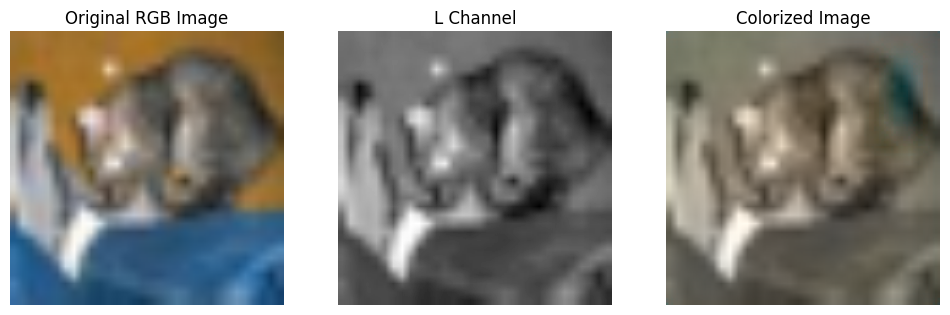

Original RGB Image Shape: (224, 224, 3)
L Channel Shape After Squeeze: (224, 224)
Predicted ab Channel Shape: (2, 224, 224)
Reshaped Predicted ab Channel Shape: (224, 224, 2)
LAB Image Shape: (224, 224, 3)


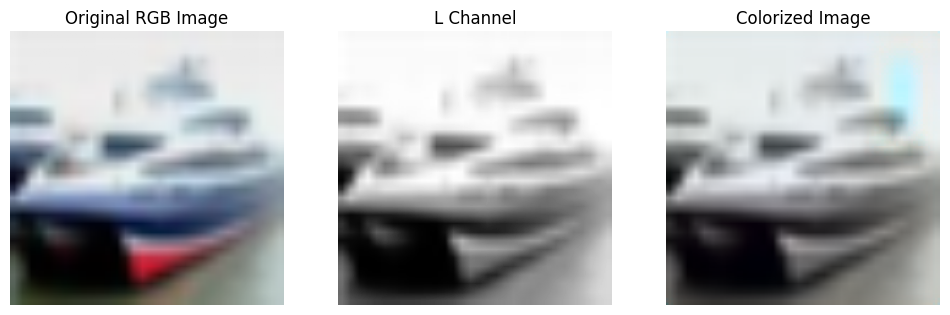

Original RGB Image Shape: (224, 224, 3)
L Channel Shape After Squeeze: (224, 224)
Predicted ab Channel Shape: (2, 224, 224)
Reshaped Predicted ab Channel Shape: (224, 224, 2)
LAB Image Shape: (224, 224, 3)


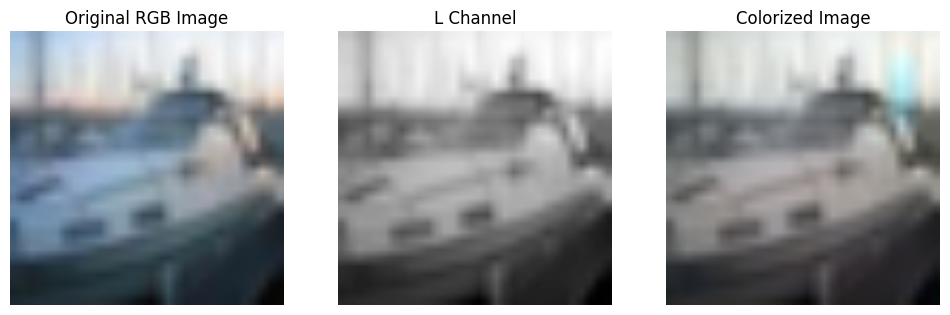

Original RGB Image Shape: (224, 224, 3)
L Channel Shape After Squeeze: (224, 224)
Predicted ab Channel Shape: (2, 224, 224)
Reshaped Predicted ab Channel Shape: (224, 224, 2)
LAB Image Shape: (224, 224, 3)


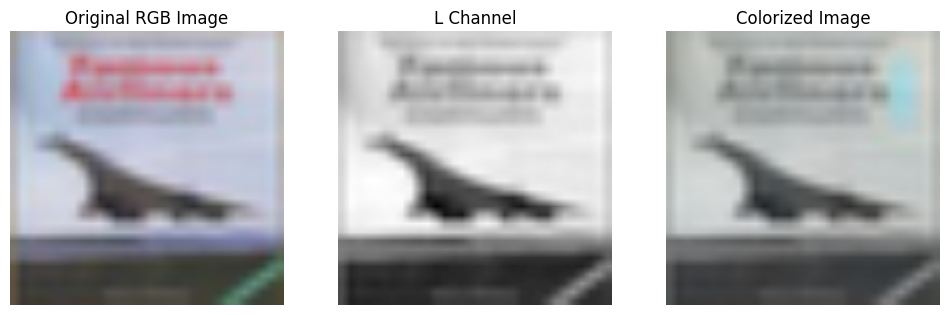

In [ ]:
# Testing and visualization
if __name__ == "__main__":
    # Visualize the model's colorization results with original images
    visualize_colorization(model, test_loader, num_images=4)

In [ ]:
!pip install lpips

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.3 MB/s eta 0:00:00


In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.5/869.5 kB 13.5 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn.functional as F
from torchvision import transforms
import torchmetrics
psnr = torchmetrics.functional.peak_signal_noise_ratio
ssim = torchmetrics.functional.structural_similarity_index_measure
import lpips  # For computing LPIPS

# Initialize LPIPS loss (AlexNet backbone for comparison)
lpips_loss_fn = lpips.LPIPS(net='alex').to(device)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:04<00:00, 51.6MB/s]


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth


/usr/local/lib/python3.10/dist-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_location='cpu'), st

In [ ]:
import torch
import torch.nn.functional as F
from skimage.color import lab2rgb
import numpy as np

# Function to evaluate the model
def evaluate_model(model, test_loader, lpips_loss_fn):
    model.eval()  # Set the model to evaluation mode
    mse_loss_fn = torch.nn.MSELoss()  # MSE loss for evaluation
    total_loss, total_mse, total_psnr, total_ssim, total_lpips = 0.0, 0.0, 0.0, 0.0, 0.0
    num_images = 0

    with torch.no_grad():  # Disable gradient computation for evaluation
        for batch in test_loader:
            images = batch[0].to(device)  # Get the original RGB images
            # print(f"Original RGB Images Shape: {images.shape}")  # Debugging statement

            # Convert RGB to L and ab channels
            L, ab = rgb_to_lab(images)
            # print(f"L Channel Shape: {L.shape}, ab Shape: {ab.shape}")  # Debugging statement

            # Add channel dimension to L (Nx1xHxW) if not already present
            if L.ndim == 3:  # Only unsqueeze if L doesn't already have the channel dimension
                L = L.unsqueeze(1)
            # print(f"L Channel Shape After Unsqueeze: {L.shape}")  # Debugging statement

            # Predict ab channels from L
            ab_pred = model(L)
            # print(f"Predicted ab Shape: {ab_pred.shape}")  # Debugging statement

            # Resize ground truth ab to match ab_pred size
            ab_resized = F.interpolate(ab, size=ab_pred.shape[2:], mode='bilinear', align_corners=False)
            # print(f"Resized Ground Truth ab Shape: {ab_resized.shape}")  # Debugging statement

            # Compute loss (MSE between predicted and ground truth ab channels)
            loss = mse_loss_fn(ab_pred, ab_resized)
            total_loss += loss.item()

            # Compute MSE for evaluation
            mse = F.mse_loss(ab_pred, ab_resized)
            total_mse += mse.item()

            # Convert to numpy for PSNR, SSIM, and LPIPS evaluation
            L_cpu = L.squeeze(1).cpu().numpy() * 100  # Denormalize L from [0, 1] to [0, 100]
            ab_cpu_gt = ab.cpu().numpy() * 255 - 128  # Denormalize ab from [0, 1] to [-128, 128]
            ab_cpu_pred = ab_pred.cpu().numpy() * 255 - 128  # Denormalize predicted ab
            # print(f"L_cpu Shape: {L_cpu.shape}, ab_cpu_gt Shape: {ab_cpu_gt.shape}, ab_cpu_pred Shape: {ab_cpu_pred.shape}")  # Debugging statement

            for i in range(L.shape[0]):  # Loop over batch images
                # Reconstruct ground truth and predicted LAB images
                lab_gt = np.concatenate([L_cpu[i][:, :, np.newaxis], ab_cpu_gt[i].transpose(1, 2, 0)], axis=2)
                lab_pred = np.concatenate([L_cpu[i][:, :, np.newaxis], ab_cpu_pred[i].transpose(1, 2, 0)], axis=2)

                # print(f"LAB GT Shape: {lab_gt.shape}, LAB Pred Shape: {lab_pred.shape}")  # Debugging statement

                # Convert Lab to RGB
                rgb_gt = lab2rgb(lab_gt)
                rgb_pred = lab2rgb(lab_pred)

                # Compute PSNR
                psnr_value = psnr(torch.tensor(rgb_pred).permute(2, 0, 1).unsqueeze(0),
                                  torch.tensor(rgb_gt).permute(2, 0, 1).unsqueeze(0), data_range=1.0)
                total_psnr += psnr_value.item()

                # Compute SSIM
                ssim_value = ssim(torch.tensor(rgb_pred).permute(2, 0, 1).unsqueeze(0),
                                  torch.tensor(rgb_gt).permute(2, 0, 1).unsqueeze(0), data_range=1.0)
                total_ssim += ssim_value.item()

                # Compute LPIPS
                lpips_value = lpips_loss_fn(torch.tensor(rgb_pred).permute(2, 0, 1).unsqueeze(0).to(device),
                                            torch.tensor(rgb_gt).permute(2, 0, 1).unsqueeze(0).to(device))
                total_lpips += lpips_value.item()

                num_images += 1  # Track number of evaluated images

    # Calculate averages
    avg_loss = total_loss / len(test_loader)
    avg_mse = total_mse / num_images
    avg_psnr = total_psnr / num_images
    avg_ssim = total_ssim / num_images
    avg_lpips = total_lpips / num_images

    return avg_loss, avg_mse, avg_psnr, avg_ssim, avg_lpips


In [ ]:
if __name__ == "__main__":
    # Evaluate the model and print results
    avg_loss, avg_mse, avg_psnr, avg_ssim, avg_lpips = evaluate_model(model, test_loader, lpips_loss_fn)

    # Print the evaluation results
    print(f"Average Test Loss: {avg_loss:.4f}")
    print(f"Average MSE: {avg_mse:.4f}")
    print(f"Average PSNR: {avg_psnr:.4f} dB")
    print(f"Average SSIM: {avg_ssim:.4f}")
    print(f"Average LPIPS: {avg_lpips:.4f}")

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `peak_signal_noise_ratio` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `peak_signal_noise_ratio` from `torchmetrics.image` instead.
  _future_warning(
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(


Average Test Loss: 0.0022
Average MSE: 0.0003
Average PSNR: 24.9831 dB
Average SSIM: 0.9544
Average LPIPS: 0.1257
